# EELS SrFeO Project 
## RNN Autoencoder - Analyzing the trained model

*Collaboration: M3 Learning at Lehigh University x Dynamic Characterization Group at Drexel University*


### Setting up autoencoder

In [45]:
import keras
from keras.models import Model
from keras.layers import Input, LSTM, Dense
from keras.models import Sequential, Input, Model
from keras.layers import (Dense, Conv1D, Convolution2D, GRU, LSTM, Recurrent, Bidirectional, TimeDistributed,
                          Dropout, Flatten, RepeatVector, Reshape, MaxPooling1D, UpSampling1D, BatchNormalization)
from keras.layers.core import Lambda
from keras.optimizers import Adam
from keras.regularizers import l1

In [46]:
def rnn_autoencoder(layer, size, N_encode, 
                    N_decode, embed, 
                    N_steps, lr = 3e-6, drop_frac = 0.01,
                    bidir = False, l1_norm = 1e-4, **kwargs):
    """
    Function which builds the reccurrent neural network autoencoder
    
    Parameters
    ----------
    layer : string; options: 'lstm','gru'
        selects the layer type
    size  : numpy, int
        sets the size of encoding and decoding layers in the network
    N_encode  : numpy, int
        sets the number of encoding layers in the network
    N_decode : numpy, int
        sets the number of decoding layers in the network
    embed : numpy, int
        sets the size of the embedding layer
    N_steps : numpy, int
        length of the input time series
    lr : numpy, float
        sets the learning rate for the model
    drop_frac : numpy, float
        sets the dropout fraction
    bidir : numpy, bool
        selects if the model is linear or bidirectional
    l1_norm : numpy. float
        sets the lambda value of the l1 normalization. The larger the value the greater the
        sparsity. None can be passed to exclude the use or l1 normailzation.
    
    Returns
    -------
    model : Keras, object
        Keras tensorflow model
    """

    model = Sequential()
    
    # wrapper for bidirectional LSTM
    if bidir: wrapper = Bidirectional
    else: wrapper = lambda x: x
        
        
    # builds the first layer
    model.add(wrapper(layer(size, return_sequences=(N_encode > 1),  dropout=drop_frac, input_shape=(N_steps, 1))))

    # builds the encoding layers
    for i in range(1, N_encode):
        model.add(wrapper(layer(size, return_sequences=(i < N_encode - 1), dropout=drop_frac)))

    # builds the embedding layer
    model.add(Dense(embed, activation='relu', name='encoding', activity_regularizer=l1(l1_norm)))

    # builds the repeat vector
    model.add(RepeatVector(N_steps))

    # builds the decoding layer
    for i in range(N_decode):
        model.add(wrapper(layer(size, return_sequences=True, dropout=drop_frac)))

    # builds the time distributed layer to reconstruct the original input
    model.add(TimeDistributed(Dense(1, activation='linear')))

    # complies the model
    model.compile(Adam(lr), loss='mse')

    # returns the model
    return model

In [47]:
def train_model(model, data_train, data_test, path, epochs, batch_size):
    """
    Function which trains the neural network
    
    Parameters
    ----------
    model : Keras, object
        model to train
    data_train  : numpy, float
        data to train the network
    data_test  : numpy, float
        data to test the network
    path : string
        sets the folder to save the data
    epochs : numpy, int
        train the network for this number of epochs
    batch_size : numpy, int
        sets the size of the batch. Batch size should be as large as possible. 
        It is however limited by the GPU memory.
    """

    #builds the filename
    filepath = path + '/weights.{epoch:02d}-{val_loss:.8f}.hdf5'
    
    # sets the control of checkpoints
    checkpoint = keras.callbacks.ModelCheckpoint(filepath, monitor='val_loss', 
                                                 verbose=0, save_best_only=True,
                                                 save_weights_only=True, 
                                                 mode='min', period=1)

    # fits the model
    model.fit(np.atleast_3d(data_train), np.atleast_3d(data_test), 
              epochs=epochs, batch_size=batch_size, callbacks=[checkpoint], 
              validation_data=(np.atleast_3d(data_train), np.atleast_3d(data_test)))

In [48]:
# construct a model
model = rnn_autoencoder(LSTM, 128, 3, 3, 16, 128)

In [49]:
model.summary()

Model: "sequential_6"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_19 (LSTM)               (None, 128, 128)          66560     
_________________________________________________________________
lstm_20 (LSTM)               (None, 128, 128)          131584    
_________________________________________________________________
lstm_21 (LSTM)               (None, 128)               131584    
_________________________________________________________________
encoding (Dense)             (None, 16)                2064      
_________________________________________________________________
repeat_vector_4 (RepeatVecto (None, 128, 16)           0         
_________________________________________________________________
lstm_22 (LSTM)               (None, 128, 128)          74240     
_________________________________________________________________
lstm_23 (LSTM)               (None, 128, 128)         

### Loading model weight

** The training stpes takes several days with our HPC, so every checkpoints are saved.

** This will also allow checking results at specific checkpoints.

In [51]:
# load weights
folder_name = 'rnn_auto_checkpoints'
model.load_weights(folder_name+"/weights.25-0.09173137.hdf5")

# Compile model (required to make predictions)
learning_rate = 3e-6
model.compile(Adam(learning_rate), loss='mse')

### Loading Data
<span style="color: red">*** Right now, I just run the DataPrep nb. Not elegant, but works the same. </span>

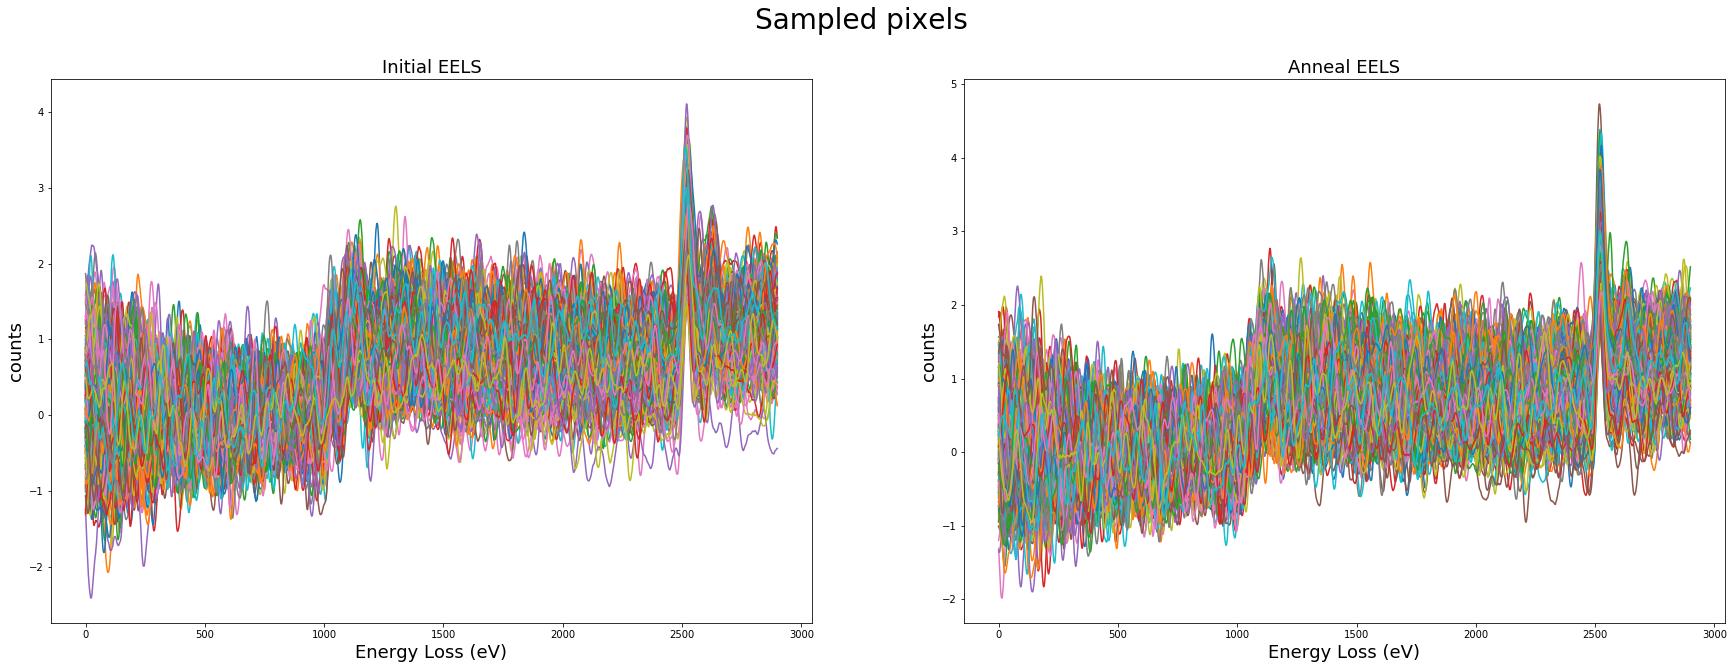

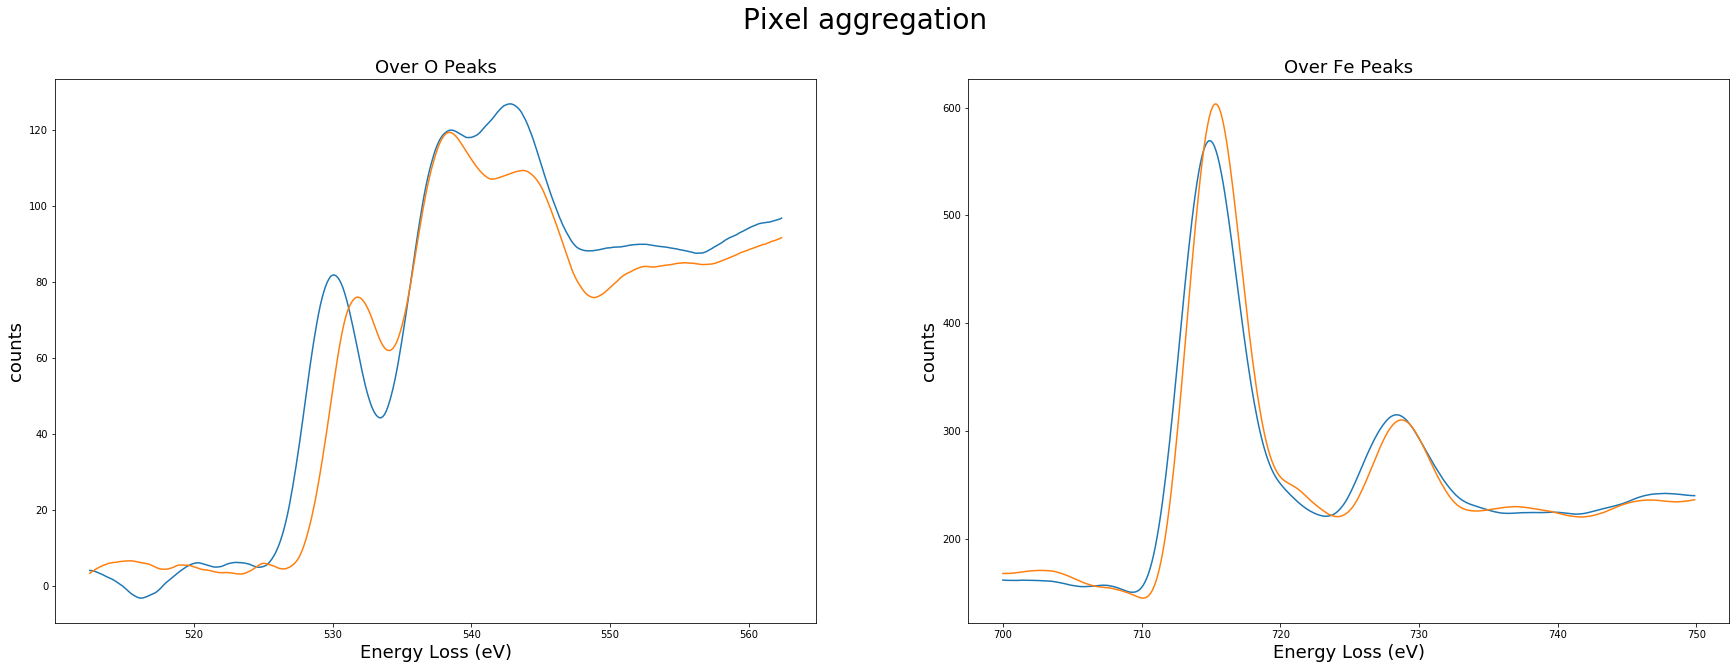

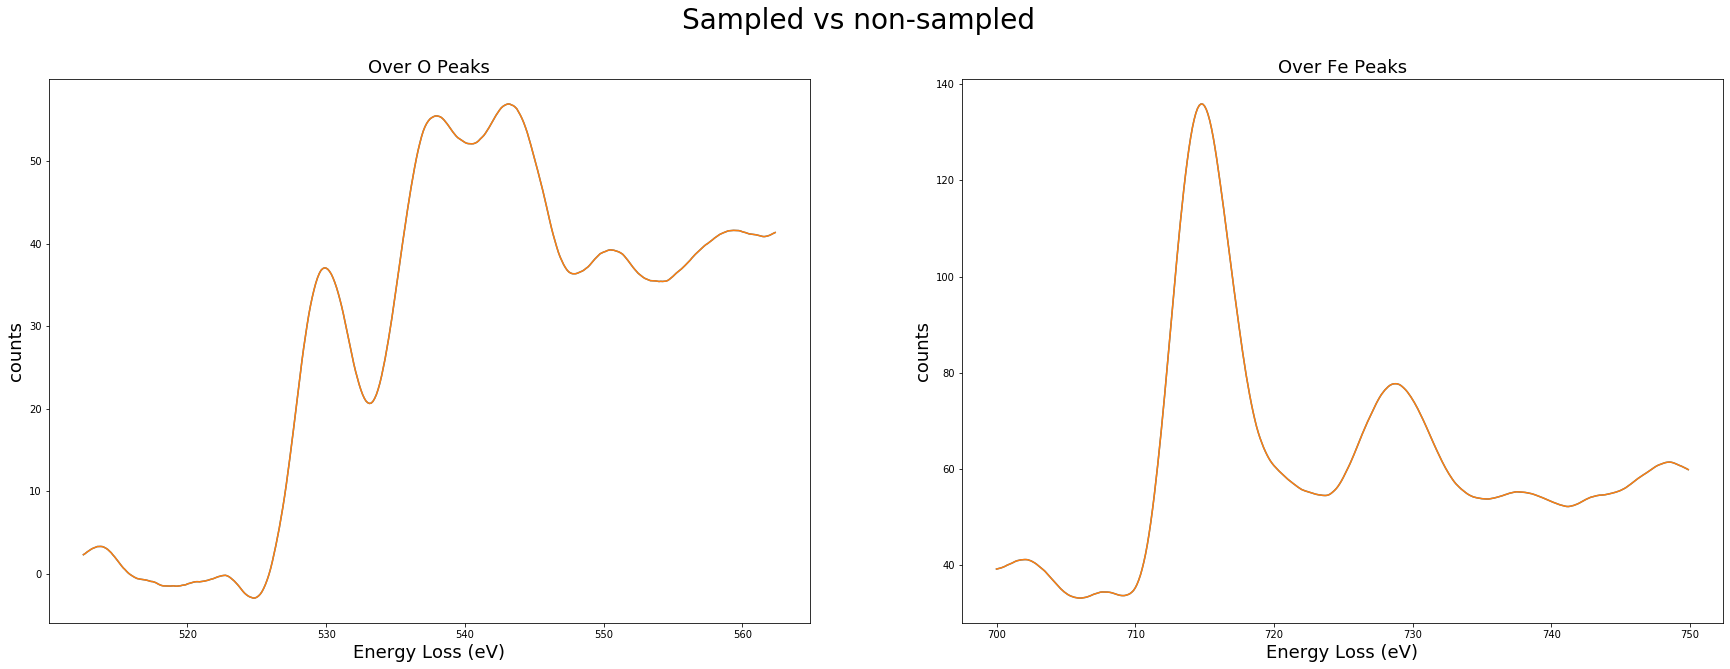

(20, 30, 300)
(20, 30, 300, 128)
(180000, 128)
(180000, 2)


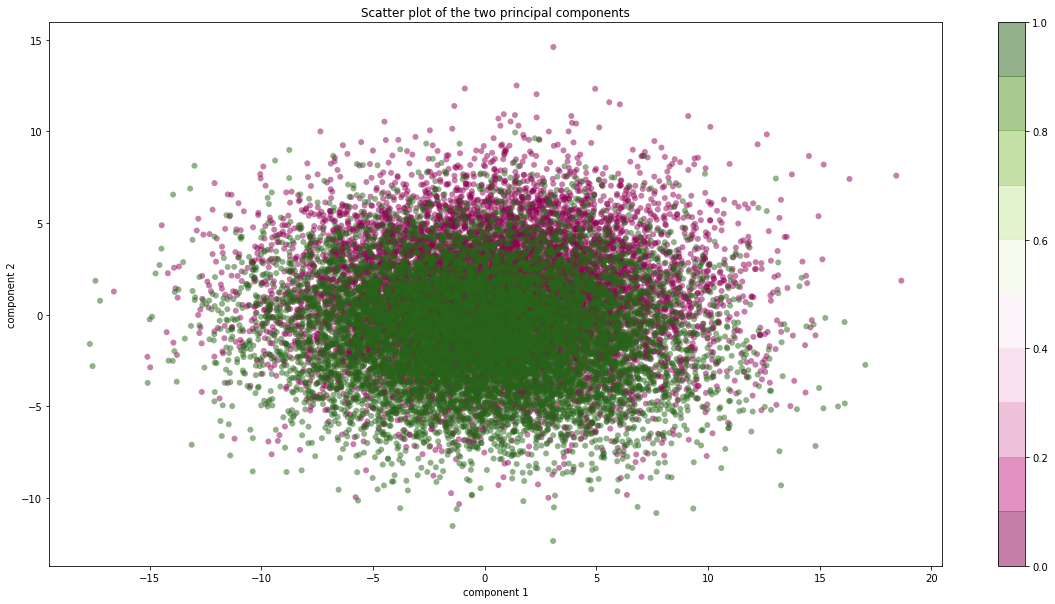

In [59]:
%run ./1_DataPrep.ipynb

In [60]:
data_ana.shape

(180000, 128)

### Visualizing low dimensional layer

#### PCA and t-SNE on the low dimensional layer for visual representation

#### Plotting spectra predictions

In [69]:
from sklearn import preprocessing

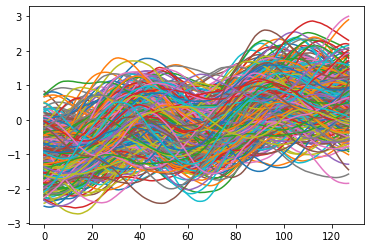

In [62]:
# Plotting some random 500 spectra
for w in range(0,500):
    plt.plot(data_ana[w+500][:])

In [ ]:
y1_results = model.predict(np.atleast_3d(data_ana))

In [ ]:
# Plotting Spectra Predictions (randomized for 36 spectra)
fig, axs = plt.subplots(6, 6, figsize=(12, 12))
y1_norm = preprocessing.normalize(data_ana)
y2_norm = preprocessing.normalize(y1_results.reshape(-1,48))
axs.reshape(-1)
for i in range (0,6):
    for j in range(0,6):
        w = np.random.randint(0, y2_norm.shape[0])
        ax = axs[i,j]
        ax.plot(y1_norm[w], label="raw spectrum") 
        ax.plot(y2_norm[w], label="predict spectrum") 
plt.legend(bbox_to_anchor=(1.1, 1.1), bbox_transform=ax.transAxes)
fig.suptitle("Spectra Prediction")

### Export results

In [ ]:
import keras.backend
import _archive.JoshCodes.viz as viz2

In [ ]:
def get_ith_layer_output(model, X, i, mode='test'):
    """
    Computes the activations of a specific layer
    see https://keras.io/getting-started/faq/#keras-faq-frequently-asked-keras-questions'
    
    Parameters
    ----------
    model : keras model, object
        pre-trained keras model
    X  : numpy array, float
        Input data
    i  : numpy, int
        index of the layer to extract
    mode : string, optional
        test or train, changes the model behavior to scale the network properly when using
        dropout or batchnorm
        
    Returns
    -------
    layer_output : float
        array containing the output from layer i of the network
    """
    # computes the output of the ith layer
    get_ith_layer = keras.backend.function([model.layers[0].input, 
                                            keras.backend.learning_phase()], 
                                           [model.layers[i].output])
    layer_output = get_ith_layer([X, 0 if mode == 'test' else 1])[0]

    return layer_output

In [ ]:
activation = get_ith_layer_output(model, np.atleast_3d(k), 3)

In [ ]:
activation.shape

In [ ]:
# plots the embedding maps
_ = viz2.plot.embedding_maps(activation,
                        printing,
                        plot_format,
                        'autoencoder/',
                        filename='./embeddings')


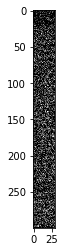

In [190]:
test = activation.reshape(10,300,30,16)
plt.imshow(test[0,:,:,1])